This script runs SARIMA models on 15 min interval data.

# Note

1. Data is not interpolated. If df does not contain NaN's then matplotlib will represent missing data with a line.

In [4]:
import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [5]:
data_folder = 'data'
site = 'avenal-movie-theatre'

# Import data

## Eagle (power) data

In [6]:
df_raw = pd.read_csv(data_folder + '/power_' + site + '.csv', index_col=[0], parse_dates=True)
df_raw = df_raw[(df_raw.index < '2019-04-01')]
df_raw.head()

,power
datetime,
2018-01-01 00:00:04.574889+00:00,400.0
2018-01-01 00:00:10.215095+00:00,440.0
2018-01-01 00:00:13.496753+00:00,440.0
2018-01-01 00:00:20.031088+00:00,440.0
2018-01-01 00:00:33.525473+00:00,400.0


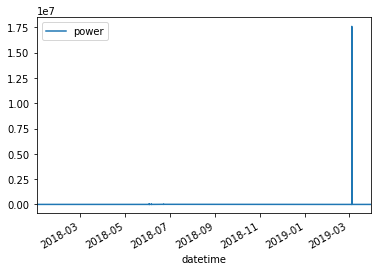

In [7]:
df_raw.plot()

## Clean data

Resample data to 15min interval, remove outliers and drop NaN's.

In [8]:
df_processed = df_raw.resample('15T').mean()
df_processed = df_processed[df_processed['power'] < 30000]
df_processed = df_processed[(np.abs(stats.zscore(df_processed)) < float(3)).all(axis=1)]
df_processed.dropna(inplace=True)
df_processed.head()

,power
datetime,
2018-01-01 00:00:00+00:00,416.991150
2018-01-01 00:15:00+00:00,477.477477
2018-01-01 00:30:00+00:00,430.990991
2018-01-01 00:45:00+00:00,504.081633
2018-01-01 01:00:00+00:00,453.565217


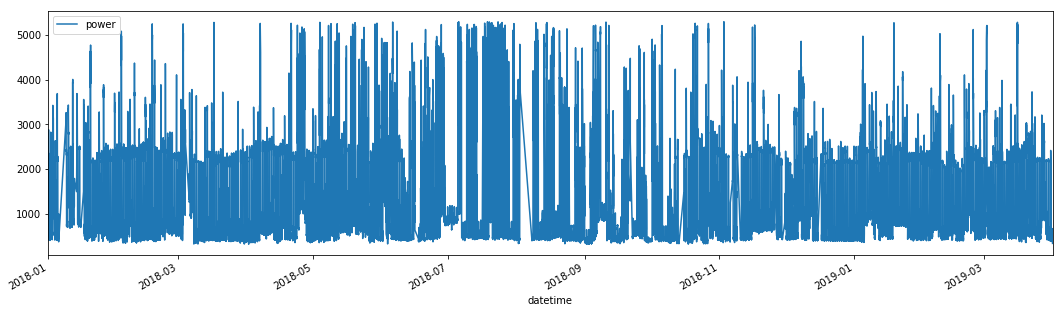

In [9]:
df_processed.plot(figsize=(18,5))

## Check for missing data

In [10]:
df_processed.isna().any()

power    False
dtype: bool

## Check for stationarity

Null Hypothesis: Data is non-stationary

p-value > Critical Value (10%) -->

In [11]:
result = adfuller(df_processed['power'], autolag='AIC')
output = pd.Series(result[0:4], index=['Test Statistics', 'p-value', '#Lags Used',
                                      '#Observations Used'])
for key, value in result[4].items():
    output['Critical Value (%s)' % key] = value
    
output

Test Statistics           -33.787110
p-value                     0.000000
#Lags Used                 44.000000
#Observations Used      39926.000000
Critical Value (1%)        -3.430514
Critical Value (5%)        -2.861612
Critical Value (10%)       -2.566809
dtype: float64

## HVAC States data

In [12]:
df_raw_hvac_states = pd.read_csv(data_folder + '/hvac_states_' + site + '.csv', index_col=[0], parse_dates=True)
df_raw_hvac_states.head()

,hvac_zone_lobby,hvac_zone_main_hallway,hvac_zone_room_a,hvac_zone_theater_2,hvac_zone_back_hallway,hvac_zone_room_d,hvac_zone_pegasus_hall,hvac_zone_theater_1
2018-01-01 00:00:00+00:00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-01 00:05:00+00:00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-01 00:10:00+00:00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-01 00:15:00+00:00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-01 00:20:00+00:00,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [13]:
missing = df_raw_hvac_states.isnull().sum()
total = df_raw_hvac_states.shape[0]
print('missing data for power:\n', (missing/total)*100)

missing data for power:
 hvac_zone_lobby           6.264120
hvac_zone_main_hallway    4.201056
hvac_zone_room_a          3.898381
hvac_zone_theater_2       4.708749
hvac_zone_back_hallway    3.973948
hvac_zone_room_d          4.026830
hvac_zone_pegasus_hall    4.581074
hvac_zone_theater_1       5.845112
dtype: float64


In [14]:
def func(row):
    """ Possible situations: (0,0,0), (1,0,1), (0,1,2) --> 0, 1, 2
    
    If all are same --> first element
    If there is a majority among the 3 --> majority
    If all are unique --> last element
    
    """

    count = len(set(list(row.values)))
    if count == 1:
        return row.values[0]
    elif count == 2:
        max(set(list(row.values)), key=list(row.values).count)
    else:
        return row.values[-1]
    
resample_df_hvac = df_raw_hvac_states.resample('15T').apply(func)

## Concatenate data

In [15]:
df = pd.concat([df_processed, resample_df_hvac], axis=1)
df.head()

,power,hvac_zone_lobby,hvac_zone_main_hallway,hvac_zone_room_a,hvac_zone_theater_2,hvac_zone_back_hallway,hvac_zone_room_d,hvac_zone_pegasus_hall,hvac_zone_theater_1
2018-01-01 00:00:00+00:00,416.991150,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-01 00:15:00+00:00,477.477477,0.0,1.0,0.0,0.0,NaN,0.0,0.0,0.0
2018-01-01 00:30:00+00:00,430.990991,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-01 00:45:00+00:00,504.081633,0.0,1.0,0.0,0.0,NaN,0.0,0.0,0.0
2018-01-01 01:00:00+00:00,453.565217,0.0,1.0,0.0,0.0,NaN,0.0,0.0,0.0


In [16]:
missing = df.isnull().sum()
total = df.shape[0]
print('missing data for power:\n', (missing/total)*100)

missing data for power:
 power                      8.491300
hvac_zone_lobby           18.195971
hvac_zone_main_hallway    13.418040
hvac_zone_room_a          11.950549
hvac_zone_theater_2       11.407967
hvac_zone_back_hallway    13.147894
hvac_zone_room_d          10.787546
hvac_zone_pegasus_hall    12.461081
hvac_zone_theater_1       12.566392
dtype: float64


# Check for stationarity

## ACF

High autocorrelation shows that the data is non-stationary

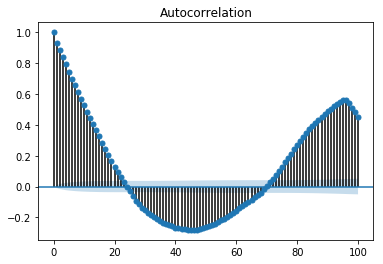

In [17]:
fig1 = plot_acf(df_processed['power'], lags=100)

## Dickey Fuller Test

In [18]:
result = adfuller(df_processed['power'], autolag='AIC')
output = pd.Series(result[0:4], index=['Test Statistics', 'p-value', '#Lags Used',
                                      '#Observations Used'])
for key, value in result[4].items():
    output['Critical Value (%s)' % key] = value
    
output

Test Statistics           -33.787110
p-value                     0.000000
#Lags Used                 44.000000
#Observations Used      39926.000000
Critical Value (1%)        -3.430514
Critical Value (5%)        -2.861612
Critical Value (10%)       -2.566809
dtype: float64

## Plotting rolling mean and std-dev

The rolling mean is constant, therefore there's no trend in the power consumption data. The std-dev is fairly constant, therefore there's not much variance in the power consumption data. This graph is probably not very useful for confirming the non-stationarity of the dataset.

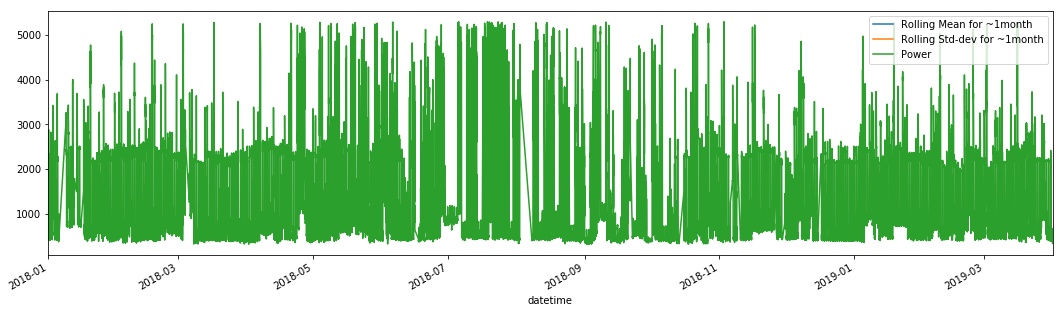

In [19]:
df_processed['power'].rolling(window=60*24*30).mean().plot(label='Rolling Mean for ~1month', figsize=(18,5))
df_processed['power'].rolling(window=60*24*30).std().plot(label='Rolling Std-dev for ~1month', figsize=(18,5))
df_processed['power'].plot(label='Power', figsize=(18,5))
plt.legend()

# Make data stationary

## ACF and PACF

We cannot use the ACF plot to determine the p value because it will show good correlations even for the lags which are far in the past, and if we consider those many features, we will have multicollinearity issues. This is not a problem with PACF plot as it removes components already explained by earlier lags, so we only get the lags which have the correlation with the residual i.e the component not explained by earlier lags.

d = 1

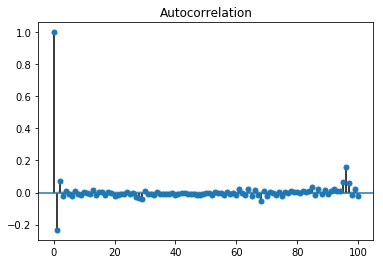

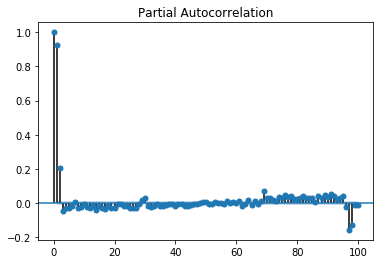

In [20]:
df_diff = df_processed.diff(1).dropna()

fig2 = plot_acf(df_diff, lags=100)
fig3 = plot_pacf(df_processed['power'], lags=100)

# Prepare data

## Split into training & testing data

In [21]:
X_train = df[(df.index < '2018-12-31')]
y_train = df.loc[(df.index < '2018-12-31'), 'power']

X_test = df[(df.index >= '2019-01-01')]
y_test = df.loc[(df.index >= '2019-01-01'), 'power']

In [22]:
endog_train_x = X_train.loc[:, 'power']
endog_train_y = y_train

endog_test_x  = X_test.loc[:, 'power']
endog_test_y  = y_test

exog_train_x  = X_train.loc[:, list(set(X_train.columns).difference(['power']))]
exog_test_x   = X_test.loc[:, list(set(X_test.columns).difference(['power']))]

In [23]:
exog_train_x.dropna(inplace=True)
exog_test_x.dropna(inplace=True)

In [24]:
# CHECK
endog_exog_train_x = pd.concat([endog_train_x, exog_train_x], axis=1).fillna(0)
endog_train_x = endog_exog_train_x.loc[:, 'power']
exog_train_x  = endog_exog_train_x.loc[:, list(set(endog_exog_train_x.columns).difference(['power']))]

In [74]:
sarimax = SARIMAX(endog=endog_train_x, exog=exog_train_x, order=(5,1,0), seasonal_order=(0,0,0,15*4*24*365))
sarimax_fit = sarimax.fit()

In [98]:
test = np.array(exog_test_x.iloc[0:16].values)
predictions = sarimax_fit.forecast(16, exog=test)

In [99]:
predictions

2018-12-31 00:00:00+00:00    417.148114
2018-12-31 00:15:00+00:00    417.494199
2018-12-31 00:30:00+00:00    417.261371
2018-12-31 00:45:00+00:00    417.235981
2018-12-31 01:00:00+00:00    417.314926
2018-12-31 01:15:00+00:00    417.382508
2018-12-31 01:30:00+00:00    417.335616
2018-12-31 01:45:00+00:00    417.342102
2018-12-31 02:00:00+00:00    402.720398
2018-12-31 02:15:00+00:00    402.720750
2018-12-31 02:30:00+00:00    402.721804
2018-12-31 02:45:00+00:00    402.722469
2018-12-31 03:00:00+00:00    402.721901
2018-12-31 03:15:00+00:00    402.722001
2018-12-31 03:30:00+00:00    402.721935
2018-12-31 03:45:00+00:00    402.721948
Freq: 15T, dtype: float64

In [84]:
start = pd.to_datetime('2018-12-31 00:00:00')
end = pd.to_datetime('2018-12-31 05:00:00')

In [90]:
df_raw.loc[start:end].resample('15T').mean()

,power
datetime,
2018-12-31 00:00:00+00:00,421.0
2018-12-31 00:15:00+00:00,432.0


In [28]:
import itertools
p = d = q = range(0, 5)
pdq = list(itertools.product(p, d, q))

In [29]:
results = {}

for param in pdq:
    try:
        model_sarima = SARIMAX(train, order=param, seasonal_order=param+(12,))
        model_sarima_fit = model_sarima.fit()
        results[str(param)] = model_sarima_fit.aic
        print(param, model_sarima_fit.aic)
    except:
        continue